Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Read.Read import open_record
from asrpy import asr_calibrate, asr_process,clean_windows
from Filtering import Basic_filters as bf
from Read.Read_zenodo import open_record as open_record_z
import time
import spkit as sp
from scipy.signal import periodogram as psd
import scipy.io
from sklearn.metrics import mutual_info_score
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import sys

Making the annotations

In [2]:
annotations=scipy.io.loadmat("D:/FYP/Zenodo EEG/zenodo_eeg/annotations_2017.mat")
fs=256

valid_ans={}
Files=[str(i) for i in range(2,25)]+[str(i) for i in range(26,62)]+[str(i) for i in range(63,80)] 
#plotting the first 5 annotations
for i in range(79):
    y0=annotations["annotat_new"][0]
    y1=y0[i]
    y2=y1[0]
    y3=y1[1]
    y4=y1[2]
    
    #y=np.multiply(np.multiply(y2,y3),y4)
    y=(y2&y3)|(y2&y4)|(y3&y4)
    #checking if y contains only 0s
    if np.any(y) and (str(i+1) in Files):
        valid_ans[str(i+1)]=np.repeat(y,fs)

loading the dataset

In [3]:
def signal_array(raw_data):
    ch1=raw_data[0]-raw_data[5]
    ch2=raw_data[5]-raw_data[7]
    ch3=raw_data[0]-raw_data[2]
    ch4=raw_data[2]-raw_data[7]
    ch5=raw_data[1]-raw_data[3]
    ch6=raw_data[3]-raw_data[8]
    ch7=raw_data[1]-raw_data[6]
    ch8=raw_data[6]-raw_data[8]
    ch9=raw_data[5]-raw_data[2]
    ch10=raw_data[2]-raw_data[4]
    ch11=raw_data[4]-raw_data[3]
    ch12=raw_data[3]-raw_data[6]
    return np.array([ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12])

valid_ans_keys=list(valid_ans.keys())
Channels=[[i] for i in range(19)] #zenodo

X=np.empty((len(Channels),))

record_num=3
X,t=open_record_z(rec_num=valid_ans_keys[record_num],frs=fs,out="all-channels")
X=signal_array(X)

#normalizing X
mu_X=np.mean(X,axis=1)
sigma_X=np.std(X,axis=1)
X=(X.T-np.array([mu_X])).T/np.array([sigma_X]).T
clean_array=bf.appy_basics(X,btype="bandpass",frs=fs)

Extracting EDF parameters from D:\FYP\Zenodo EEG\zenodo_eeg\eeg9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


d:\FYP\Code\Read\Read_zenodo.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).


Preprocessing the signal

In [15]:
beta_val=0.1
k_1=0.1
k_2=1
#normal 27000-31000
#seizure 33000-37000
t1=27000
t2=31000
Wlt_clean_arr=sp.eeg.ATAR(clean_array[:,t1:t2].T, wv='db4', winsize=128*2, beta=beta_val, thr_method='ipr', OptMode='soft', verbose=0,k1=k_1,k2=k_2).T

#apply a low pass filter to the data
Wlt_clean_arr=bf.appy_basics(Wlt_clean_arr,btype="lowpass",frs=fs)

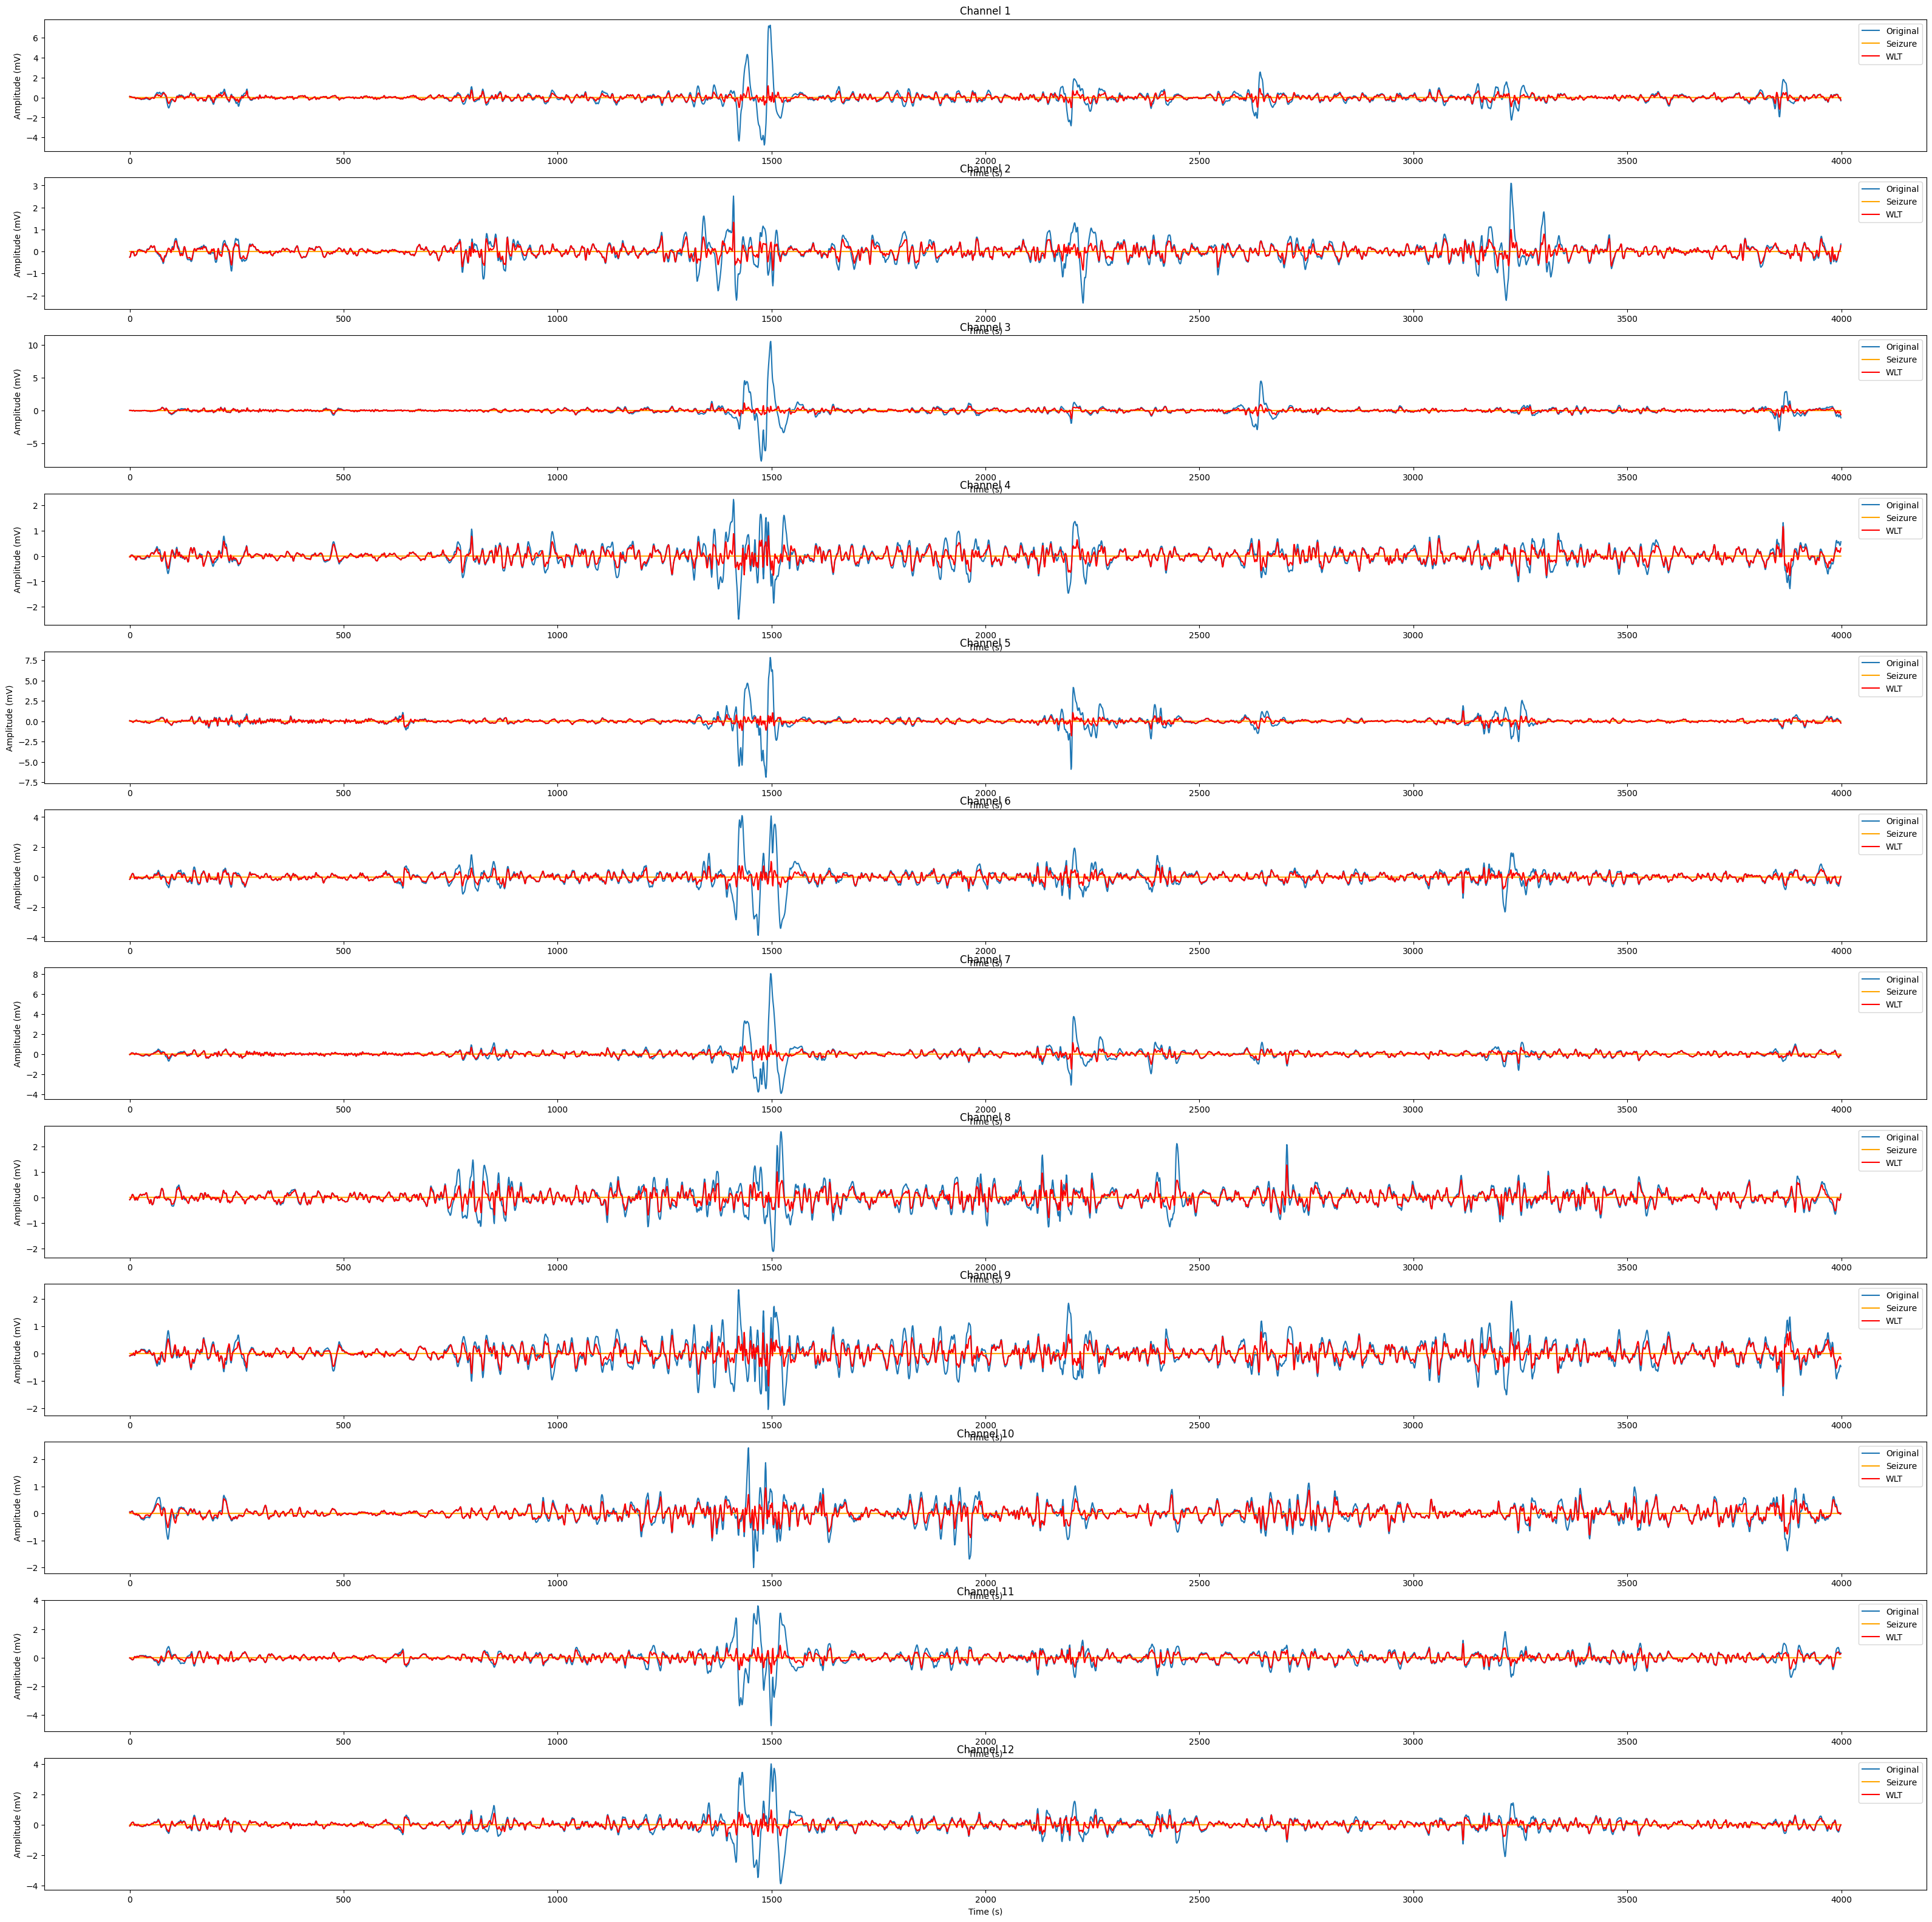

In [16]:
#plotting the dataset (the first 8 channels)
ax,fig=plt.subplots(12,1,figsize=(40,40))
for i in range(12):
    sig_art=np.multiply(clean_array[i,t1:t2],valid_ans[valid_ans_keys[record_num]][t1:t2])
    t_art=np.multiply(t[t1:t2],valid_ans[valid_ans_keys[record_num]][t1:t2])
    fig[i].plot(clean_array[i,t1:t2])
    fig[i].plot(sig_art,color="orange")
    fig[i].plot(Wlt_clean_arr[i,:],color="red")
    fig[i].set_title("Channel "+str(i+1))
    fig[i].set_xlabel("Time (s)")
    fig[i].set_ylabel("Amplitude (mV)")
    fig[i].legend(["Original","Seizure","WLT"])

Visualizing the frequency components with the change of wavelet

In [67]:
wavelets=["db{0}".format(i) for i in range(3,16,3)]
cleaned_data=[]
t1=1
t2=-1
for w in wavelets:
    Wlt_clean_arr=sp.eeg.ATAR(clean_array[:,t1:t2].T, wv=w, winsize=128, beta=beta_val, thr_method='ipr', OptMode='soft', verbose=0,k1=k_1,k2=k_2).T
    #apply a low pass filter to the data
    Wlt_clean_arr=bf.appy_basics(Wlt_clean_arr,btype="lowpass",frs=fs)
    cleaned_data.append(Wlt_clean_arr)


Analysing the frequency responses

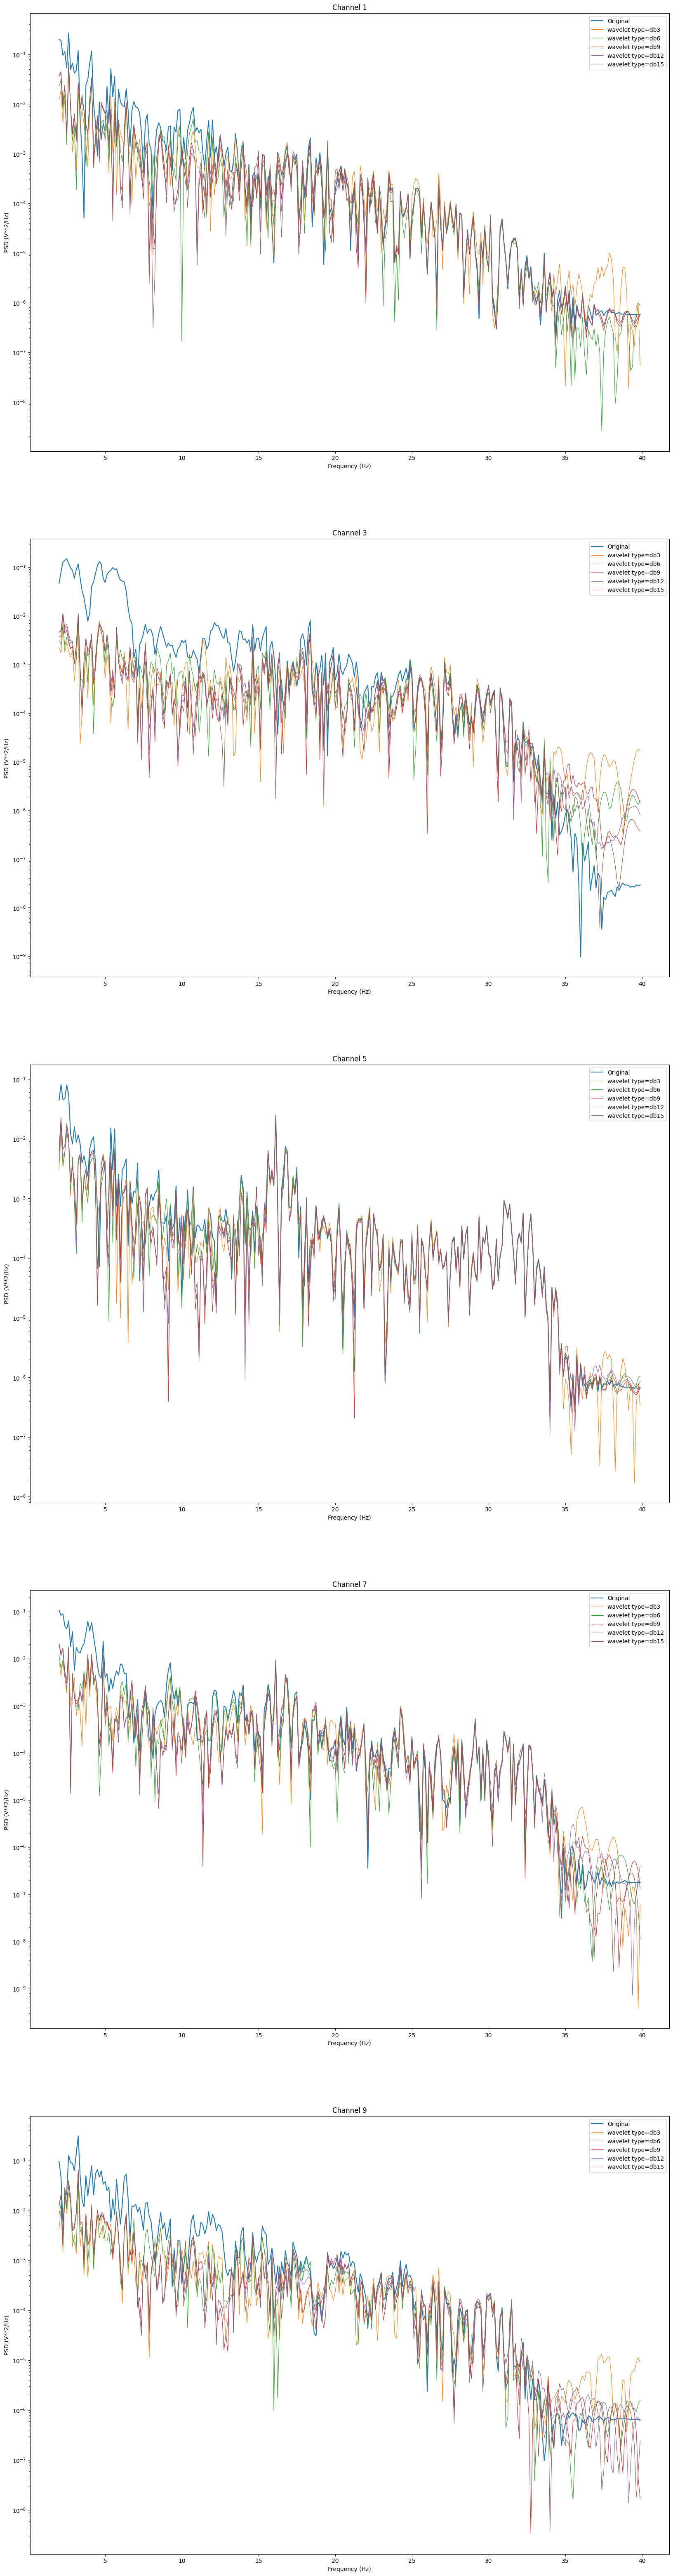

In [71]:
ax,fig=plt.subplots(5,1,figsize=(20,80))
nfft_=1024
ff=nfft_//128
f_1,f_2=2,40
for i in range(0,10,2):
    f1_clean_arrS=[]
    Pxx_den1_clean_arrS=[]
    k=i//2
    f1, Pxx_den1 = psd(clean_array[i,t1:t2], fs,nfft=nfft_)
    fig[k].semilogy(f1[f_1*ff:f_2*ff], Pxx_den1[f_1*ff:f_2*ff])
    for j in range(len(wavelets)):
        f2, Pxx_den2 = psd(cleaned_data[j][i,:], fs,nfft=nfft_)
        f1_clean_arrS.append(f2)
        Pxx_den1_clean_arrS.append(Pxx_den2)
    for j in range(len(wavelets)):
        fig[k].semilogy(f1_clean_arrS[j][f_1*ff:f_2*ff], Pxx_den1_clean_arrS[j][f_1*ff:f_2*ff],linewidth=0.8)
    fig[k].set_title("Channel "+str(i+1))
    fig[k].set_xlabel("Frequency (Hz)")
    fig[k].set_ylabel("PSD (V**2/Hz)")
    fig[k].legend(["Original"]+["wavelet type="+str(i) for i in wavelets])

checking with varying k2

In [43]:
k2_list=[i for i in np.arange(0.1,2,0.3)]
cleaned_data=[]
t1=10000
t2=20000
for k in k2_list:
    Wlt_clean_arr=sp.eeg.ATAR(clean_array[:,t1:t2].T, wv='db3', winsize=128, beta=beta_val, thr_method='ipr', OptMode='soft', verbose=0,k1=k_1,k2=k).T
    #apply a low pass filter to the data
    Wlt_clean_arr=bf.appy_basics(Wlt_clean_arr,btype="lowpass",frs=fs)
    cleaned_data.append(Wlt_clean_arr)


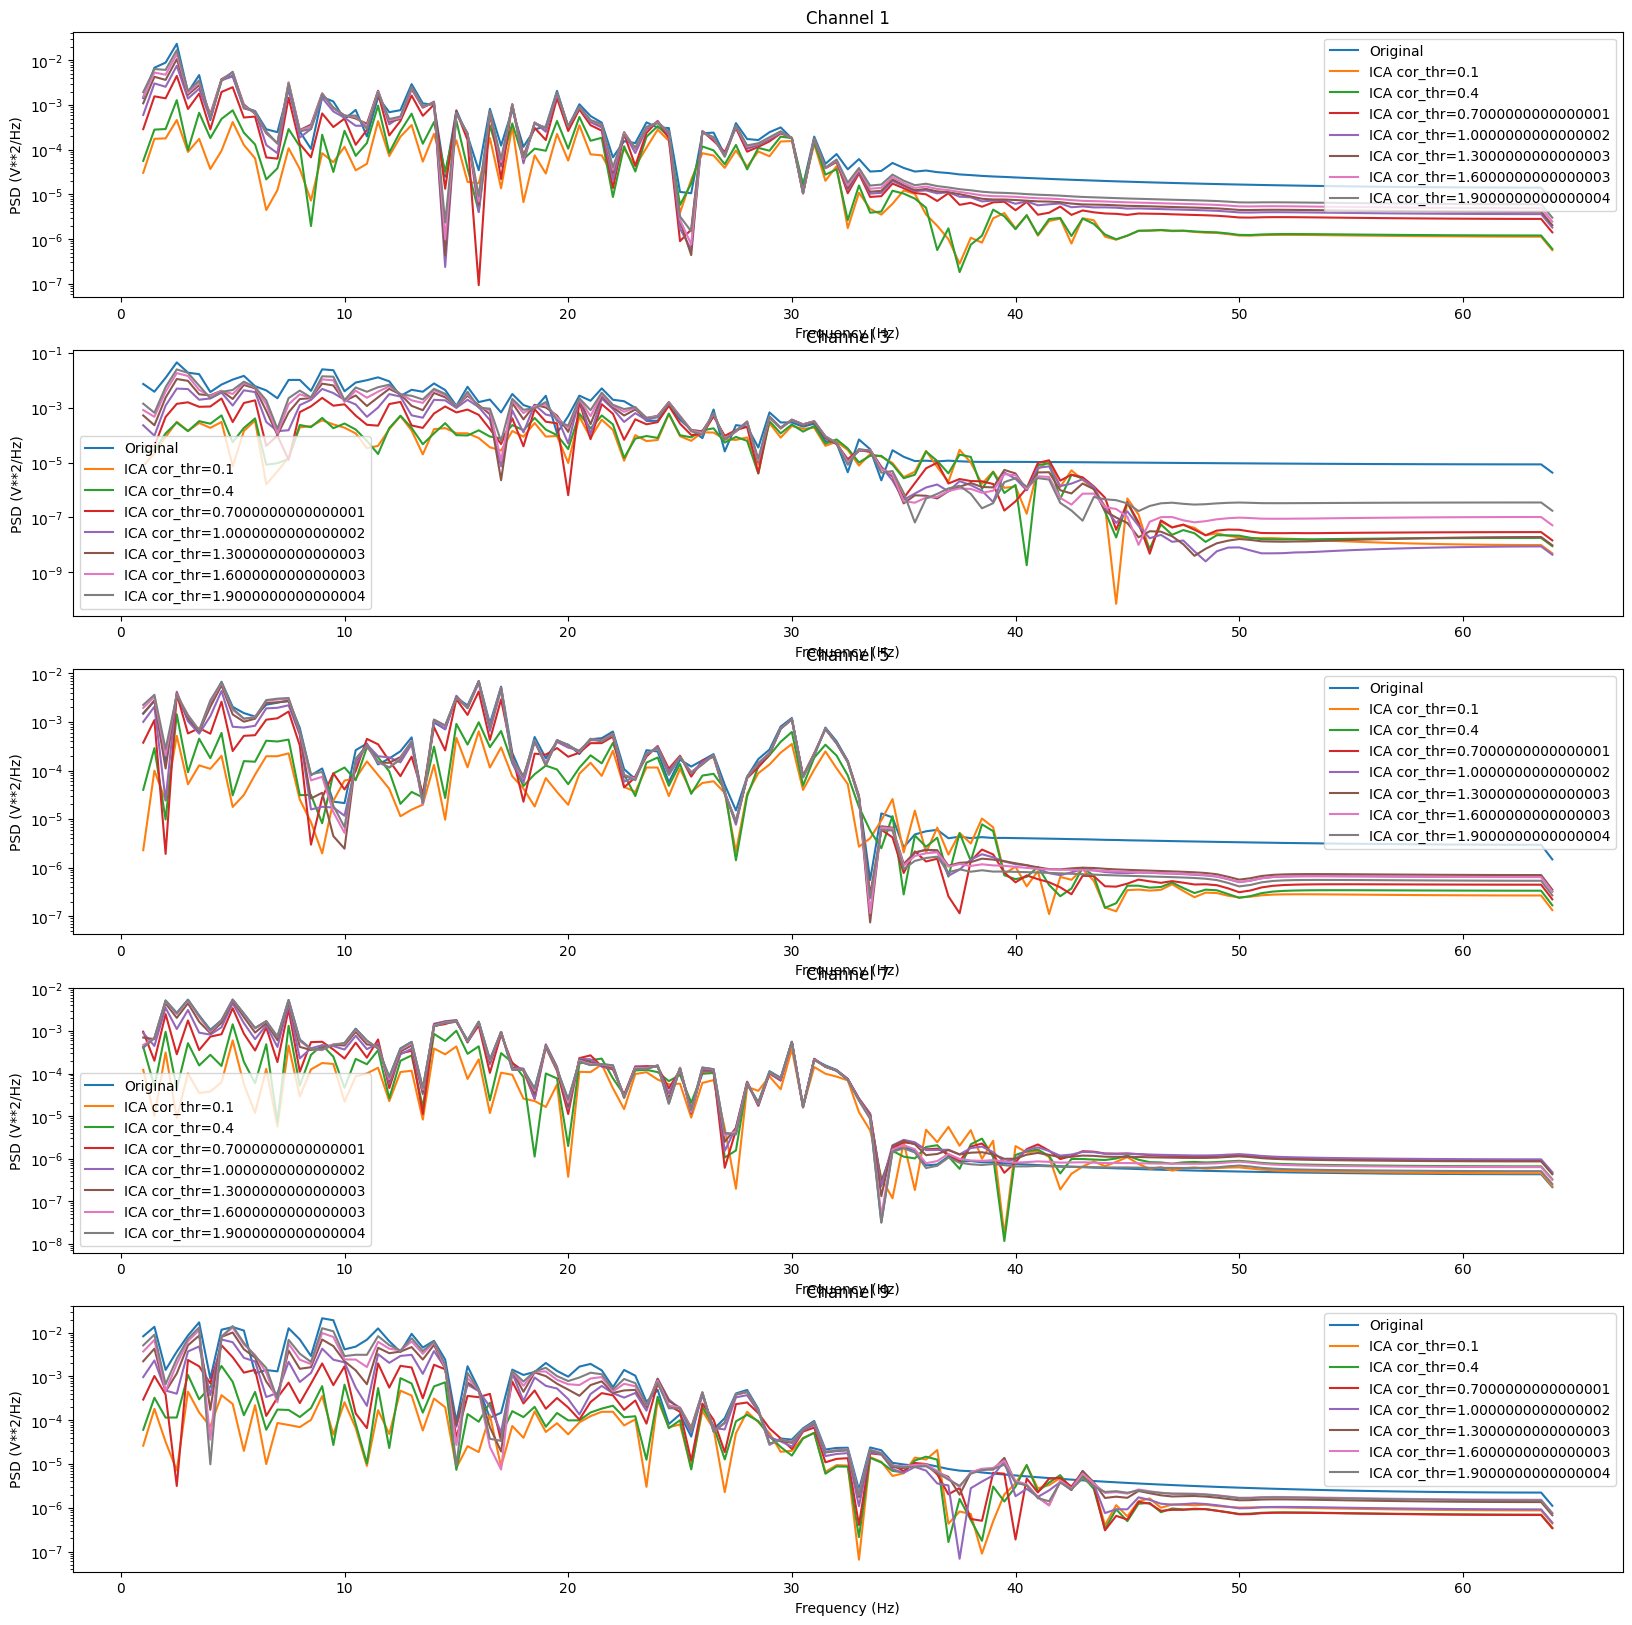

In [44]:
ax,fig=plt.subplots(5,1,figsize=(20,20))
nfft_=1024//4
for i in range(0,10,2):
    f1_clean_arrS=[]
    Pxx_den1_clean_arrS=[]
    k=i//2
    f1, Pxx_den1 = psd(clean_array[i,t1:t2], fs,nfft=nfft_)
    fig[k].semilogy(f1[2:], Pxx_den1[2:])
    for j in range(len(k2_list)):                               #change here
        f2, Pxx_den2 = psd(cleaned_data[j][i,:], fs,nfft=nfft_)
        f1_clean_arrS.append(f2)
        Pxx_den1_clean_arrS.append(Pxx_den2)
    for j in range(len(k2_list)):                               #change here
        fig[k].semilogy(f1_clean_arrS[j][2:], Pxx_den1_clean_arrS[j][2:])
    fig[k].set_title("Channel "+str(i+1))
    fig[k].set_xlabel("Frequency (Hz)")
    fig[k].set_ylabel("PSD (V**2/Hz)")
    fig[k].legend(["Original"]+["ICA cor_thr="+str(i) for i in k2_list])      #change here

In [34]:
k1_list=[i for i in np.arange(0.01,0.5,0.03)]
k_2=1
cleaned_data=[]
t1=33000
t2=37000
for k in k1_list:
    Wlt_clean_arr=sp.eeg.ATAR(clean_array[:,t1:t2].T, wv='db3', winsize=128, beta=beta_val, thr_method='ipr', OptMode='soft', verbose=0,k1=k,k2=k_2).T
    #apply a low pass filter to the data
    Wlt_clean_arr=bf.appy_basics(Wlt_clean_arr,btype="lowpass",frs=fs)
    cleaned_data.append(Wlt_clean_arr)

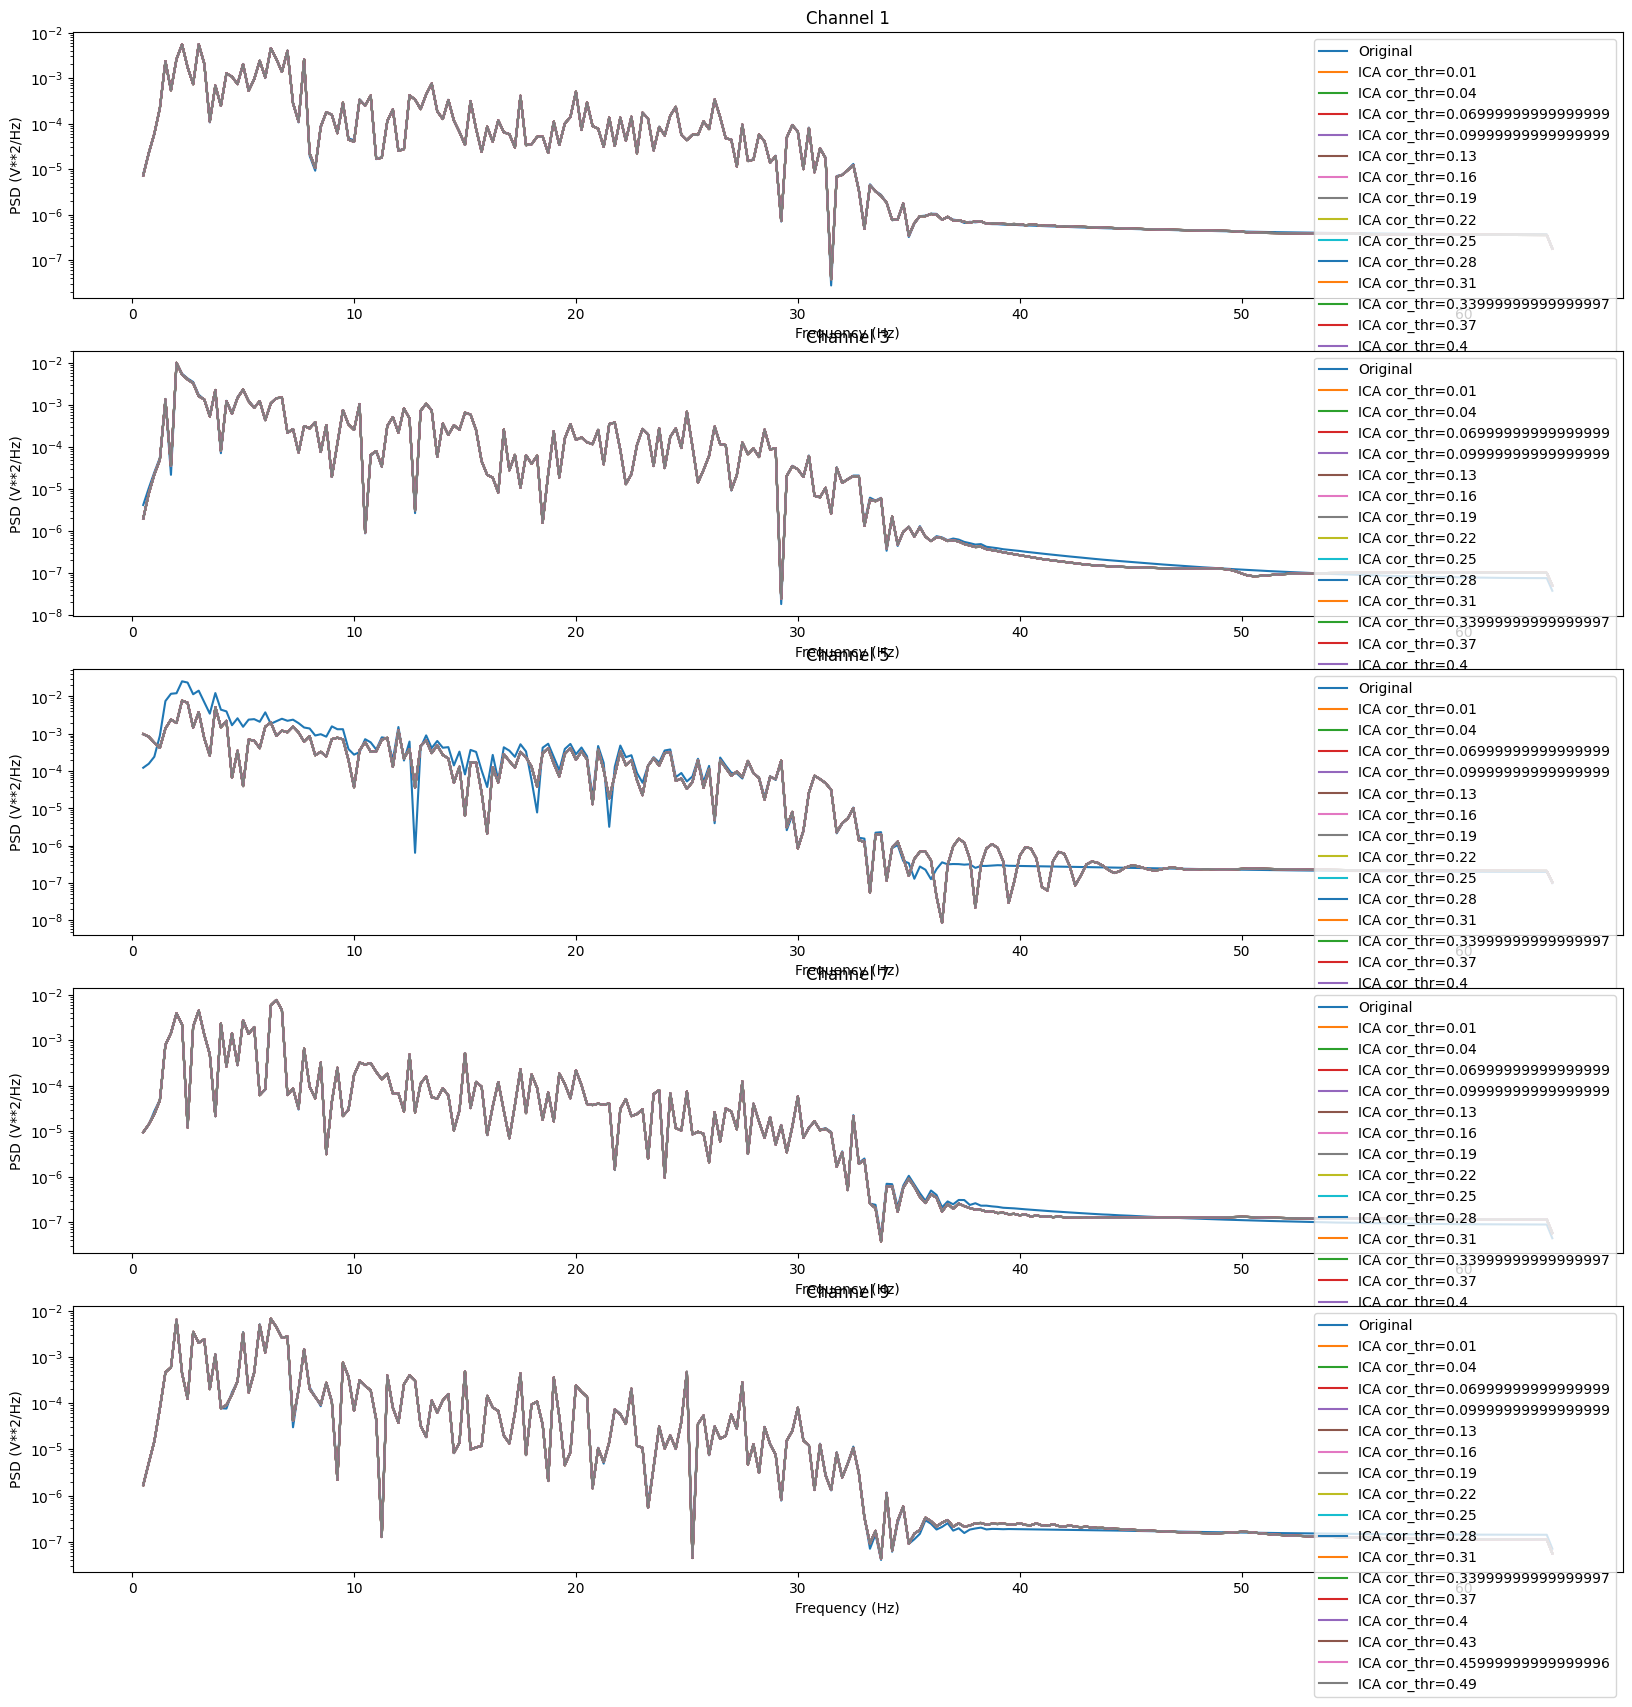

In [41]:
ax,fig=plt.subplots(5,1,figsize=(20,20))
nfft_=1024//2
for i in range(0,10,2):
    f1_clean_arrS=[]
    Pxx_den1_clean_arrS=[]
    k=i//2
    f1, Pxx_den1 = psd(clean_array[i,t1:t2], fs,nfft=nfft_)
    fig[k].semilogy(f1[2:], Pxx_den1[2:])
    for j in range(len(k1_list)):                               #change here
        f2, Pxx_den2 = psd(cleaned_data[j][i,:], fs,nfft=nfft_)
        f1_clean_arrS.append(f2)
        Pxx_den1_clean_arrS.append(Pxx_den2)
    for j in range(len(k1_list)):                               #change here
        fig[k].semilogy(f1_clean_arrS[j][2:], Pxx_den1_clean_arrS[j][2:])
    fig[k].set_title("Channel "+str(i+1))
    fig[k].set_xlabel("Frequency (Hz)")
    fig[k].set_ylabel("PSD (V**2/Hz)")
    fig[k].legend(["Original"]+["ICA cor_thr="+str(i) for i in k1_list])      #change here